In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import random

import transformers

from model import TrajectoryModel
from trajectory_gpt2 import GPT2Model
from modeling_bert import BertModel

from matplotlib import pyplot as plt

import gymnasium as gym
import argparse
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading the trajectories from data

In [3]:
traj_states = torch.load("data/pendulum_states.pt")
traj_actions = torch.load("data/pendulum_actions.pt")
traj_states.to(device)
traj_states.to(device)
state_dim  = traj_states.size()[2]
act_dim  = 1
n_traj = traj_states.size()[0]
traj_len = traj_states.size()[1]

## Normalizing the data

In [4]:
# torch.mean(traj_states, dim = 0).repeat(n_traj, 1, 1)
# torch.mean(traj_actions, dim = 0).repeat(n_traj, 1, 1)

## Splitting the data into Training and Testing set

In [5]:
train_traj_states = traj_states[0:int(0.95*n_traj),:,:]
train_traj_actions = traj_actions[0:int(0.95*n_traj),:]

n_train_traj = train_traj_states.size()[0]

test_traj_states = traj_states[int(0.95*n_traj):,:,:]
test_traj_actions = traj_actions[int(0.95*n_traj):,:]

n_test_traj = test_traj_states.size()[0]

## Function to obtain batch of trajectories

In [6]:
def get_batch(batch_size, n_traj, traj_states, traj_actions):
    idxs = random.choices(range(n_traj), k=batch_size)
    batch_states = traj_states[idxs,:,:]
    batch_actions = traj_actions[idxs,:]
    
    return batch_states, batch_actions.unsqueeze(-1)

## Decision Transformer Code

In [10]:
class TransDynaMo(TrajectoryModel):

    """
    This model uses GPT to model (state_1, action_1, state_2, action_2, ...)
    """

    def __init__(
            self,
            state_dim,
            act_dim,
            hidden_size,
            max_length=None,
            max_ep_len=200,
            action_tanh=True,
            **kwargs
    ):
        super().__init__(state_dim, act_dim, max_length=max_length)

        self.hidden_size = hidden_size
        config = transformers.BertConfig(
            vocab_size=1,  # doesn't matter -- we don't use the vocab
            n_embd=hidden_size,
            **kwargs
        )

        # note: the only difference between this GPT2Model and the default Huggingface version
        # is that the positional embeddings are removed (since we'll add those ourselves)
        self.transformer = BertModel(config)

        self.embed_timestep = nn.Embedding(max_ep_len, hidden_size)
        self.embed_state = torch.nn.Linear(self.state_dim, hidden_size)
        self.embed_action = torch.nn.Linear(self.act_dim, hidden_size)

        self.embed_ln = nn.LayerNorm(hidden_size)

        self.predict_state = torch.nn.Linear(hidden_size, self.state_dim)
        self.predict_action = nn.Sequential(
            *([nn.Linear(hidden_size, self.act_dim)] + ([nn.Tanh()] if action_tanh else []))
        )
        self.predict_return = torch.nn.Linear(hidden_size, 1)

    def forward(self, states, actions, timesteps, attention_mask=None):
        
        states = states.to(device)
        actions = actions.to(device)

        batch_size, seq_length = states.shape[0], states.shape[1]

        if attention_mask is None:
            # attention mask for GPT: 1 if can be attended to, 0 if not

            # Create an attention mask tensor of shape (batch_size, seq_length, seq_length) with ones on the diagonal and below
            attention_mask = torch.ones((batch_size, seq_length), device = device, dtype=torch.long)
        
        ones_matrix = torch.triu(torch.ones(seq_length, seq_length)*float('-inf'), diagonal=1)
        encoder_attention_mask = ones_matrix.unsqueeze(0).repeat(batch_size, 1, 1)
        zeros_matrix = torch.zeros(batch_size, seq_length, seq_length)

        # embed each modality with a different head
        state_embeddings = self.embed_state(states)
        action_embeddings = self.embed_action(actions)
        time_embeddings = self.embed_timestep(timesteps)

        # time embeddings are treated similar to positional embeddings
        state_embeddings = state_embeddings + time_embeddings
        action_embeddings = action_embeddings + time_embeddings
        

        # which works nice in an autoregressive sense since states predict actions
        stacked_inputs = torch.stack(
            (state_embeddings, action_embeddings), dim=1
        ).permute(0, 2, 1, 3).reshape(batch_size, 2*seq_length, self.hidden_size)
        stacked_inputs = self.embed_ln(stacked_inputs)

        # to make the attention mask fit the stacked inputs, have to stack it as well
        stacked_attention_mask = torch.stack(
            (attention_mask, attention_mask), dim=1
        ).permute(0, 2, 1).reshape(batch_size, 2*seq_length)
        
        combined_mask_top = torch.cat([encoder_attention_mask, zeros_matrix], dim=2)
        combined_mask_bottom = torch.cat([zeros_matrix, encoder_attention_mask], dim=2)
        stacked_encoder_attention_mask = torch.cat([combined_mask_top, combined_mask_bottom], dim=1).to(device)
        
        print(stacked_inputs.size())
        # we feed in the input embeddings (not word indices as in NLP) to the model
        transformer_outputs = self.transformer(
            inputs_embeds=stacked_inputs,
            attention_mask=stacked_attention_mask,
            encoder_attention_mask = stacked_encoder_attention_mask
        )
        x = transformer_outputs['last_hidden_state']

        # reshape x so that the second dimension corresponds to the original
        # returns (0), states (1), or actions (2); i.e. x[:,1,t] is the token for s_t
        x = x.reshape(batch_size, seq_length, 2, self.hidden_size).permute(0, 2, 1, 3)

        # get predictions
        state_preds = self.predict_state(x[:,1])    # predict next state given state and action
        action_preds = self.predict_action(x[:,0])  # predict next action given state

        return state_preds, action_preds

    def get_state(self, states, actions, timesteps, **kwargs):

        states = states.reshape(1, -1, self.state_dim)
        actions = actions.reshape(1, -1, self.act_dim)
        timesteps = timesteps.reshape(1, -1)

        if self.max_length is not None:
            states = states[:,-self.max_length:]
            actions = actions[:,-self.max_length:]
            timesteps = timesteps[:,-self.max_length:]

            # pad all tokens to sequence length
            attention_mask = torch.cat([torch.zeros(self.max_length-states.shape[1]), torch.ones(states.shape[1])])
            attention_mask = attention_mask.to(dtype=torch.long, device=states.device).reshape(1, -1)
            states = torch.cat(
                [torch.zeros((states.shape[0], self.max_length-states.shape[1], self.state_dim), device=states.device), states],
                dim=1).to(dtype=torch.float32)
            actions = torch.cat(
                [torch.zeros((actions.shape[0], self.max_length - actions.shape[1], self.act_dim),
                             device=actions.device), actions],
                dim=1).to(dtype=torch.float32)
            timesteps = torch.cat(
                [torch.zeros((timesteps.shape[0], self.max_length-timesteps.shape[1]), device=timesteps.device), timesteps],
                dim=1
            ).to(dtype=torch.long)
        else:
            attention_mask = None

        state_preds, action_preds = self.forward(
            states, actions, timesteps, attention_mask=attention_mask, **kwargs)
        
#         print(state_preds.size())
#         print(state_preds[0,-1].size())

        return state_preds[0,-1]

In [14]:
model = TransDynaMo(
            state_dim=state_dim,
            act_dim=act_dim,
            max_length=20,
            max_ep_len=200,
            hidden_size=768,
            n_layer=3,
            n_head=4,
            n_inner=4*128,
            activation_function='relu',
            n_positions=1024,
            resid_pdrop=0.1,
            attn_pdrop=0.1,
            n_ctx=600
        )

## Training

In [ ]:
model.to(device)
batch_size = 64
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.1,
    weight_decay=1e-4,
)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda steps: min((steps+1)/10000, 1)
)

n_epochs = 600

train_losses = torch.zeros(n_epochs)

for n in range(n_epochs):
    state_batch, action_batch = get_batch(batch_size, n_train_traj, train_traj_states, train_traj_actions)

    state_pred, action_preds = model.forward(state_batch, action_batch, (torch.arange(0,traj_len,1).unsqueeze(0)).to(device))

    loss = nn.MSELoss()
    l = loss(state_pred,state_batch.to(device))
    train_losses[n] = l.detach().cpu().item()
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    scheduler.step()

torch.Size([64, 400, 768])
torch.Size([64, 400, 768])
torch.Size([64, 400, 768])
torch.Size([64, 400, 768])
torch.Size([64, 400, 768])
torch.Size([64, 400, 768])
torch.Size([64, 400, 768])
torch.Size([64, 400, 768])
torch.Size([64, 400, 768])
torch.Size([64, 400, 768])


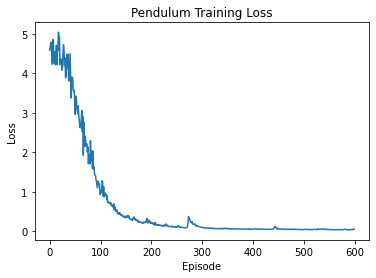

In [10]:
plt.plot(train_losses)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Pendulum Training Loss")
plt.savefig("figures/pendulum_training_loss_mse.pdf")

## Evaluation

In [11]:
model.eval()

n_eval = 100
eval_losses = torch.zeros(n_eval)

#states_eval_batch, actions_eval_batch = get_batch(n_eval, n_test_traj, test_traj_states, test_traj_actions)

for n in range(n_eval):

    states_eval_batch, actions_eval_batch = get_batch(1, n_test_traj, test_traj_states, test_traj_actions)
    state = states_eval_batch[0,0,:]
    action = actions_eval_batch[0,0,:]

    # we keep all the histories on the device
    # note that the latest action will be "padding"
    states = state.reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = action.reshape(1, act_dim).to(device=device, dtype=torch.float32)
    sim_states = []

    episode_return, episode_length = 0, 0
    for t in range(199):

        # add padding
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)

        pred_state = model.get_state(
            states.to(dtype=torch.float32) ,
            actions.to(dtype=torch.float32),
            (torch.arange(0,t+1,1).unsqueeze(0)).to(device)
        )

        actions[-1] = actions_eval_batch[0,t+1,:].reshape(1, act_dim)

        cur_state = (pred_state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        
    loss = nn.MSELoss()
    l = loss(states.unsqueeze(0),states_eval_batch.to(device))
    eval_losses[n] = l.detach().cpu().item()

In [18]:
eval_losses

tensor([ 2.8652, 11.3854, 10.1534, 19.3637, 11.9350, 14.4933, 18.8795, 14.3929,
        13.0315, 10.9156,  9.7516,  9.8873,  7.4606,  9.9586, 17.1510,  6.9577,
         9.1394,  9.5089, 11.3910, 10.8387, 11.2398, 11.1177, 12.2353,  9.5529,
        12.7785,  7.5288, 11.0967,  2.3882, 16.0707, 12.2143,  7.2212,  9.2056,
        13.5754, 14.3474,  8.3758,  8.7811,  9.3008,  9.8556, 11.8955, 16.9138,
        11.8489, 13.2936,  7.6673,  7.8541, 11.5808, 14.1949, 14.7854,  8.0069,
         8.1875,  3.8581,  9.2423, 10.8943, 15.1292, 17.8280, 12.2237,  8.9633,
        13.0355, 15.1132, 16.9730, 15.0764, 14.8998, 13.2761, 11.9414, 12.8659,
        13.1170, 13.9111, 13.9304, 16.8230,  9.9843, 14.5120,  3.3537, 14.5500,
        10.7072,  7.8195,  8.4465, 10.5044, 15.4036,  9.8840, 13.5777,  8.8857,
         7.4257, 13.0544,  9.1773,  7.8838, 12.3756, 14.0976,  3.9409,  5.8899,
         7.3099, 15.6149,  9.4845, 13.6535, 13.0315, 16.9202, 15.7865,  7.3309,
        17.5140, 10.4533,  6.7086, 13.70

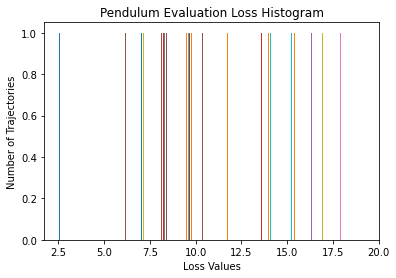

In [19]:
plt.hist(eval_losses)
plt.xlabel("Loss Values")
plt.ylabel("Number of Trajectories")
plt.title("Pendulum Evaluation Loss Histogram")
plt.savefig("figures/pendulum_evaluation_loss_hist_mse.pdf")

In [13]:
model.eval()

n_min = torch.argmin(eval_losses).item()

n_eval = 1
eval_losses_2 = torch.zeros(199)

#states_i, actions_i = states_eval_batch[n_min,:,:].unsqueeze(0), actions_eval_batch[n_min,:,:].unsqueeze(0)

for n in range(n_eval):

    states_i, actions_i = get_batch(1, n_test_traj, test_traj_states, test_traj_actions)

    state = states_i[0,0,:]
    action = actions_i[0,0,:]

    # we keep all the histories on the device
    # note that the latest action will be "padding"
    states = state.reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = action.reshape(1, act_dim).to(device=device, dtype=torch.float32)
    sim_states = []

    episode_return, episode_length = 0, 0
    for t in range(199):

        # add padding
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)

        pred_state = model.get_state(
            states.to(dtype=torch.float32) ,
            actions.to(dtype=torch.float32),
            (torch.arange(0,t+1,1).unsqueeze(0)).to(device)
        )

        actions[-1] = actions_i[0,t+1].reshape(1, act_dim)

        cur_state = (pred_state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        
#         print(states.size())
#         print(states_i[0,0:t+2,:].size())
        
        loss = nn.MSELoss()
        l = loss(states,(states_i[0,0:t+2,:]).to(device))
        eval_losses_2[t] = l.detach().cpu().item()

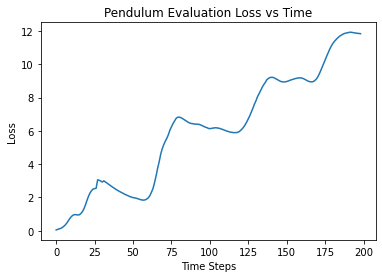

In [14]:
plt.plot(eval_losses_2)
plt.xlabel("Time Steps")
plt.ylabel("Loss")
plt.title("Pendulum Evaluation Loss vs Time")
plt.savefig("figures/pendulum_evaluation_loss_time_mse_2.pdf")

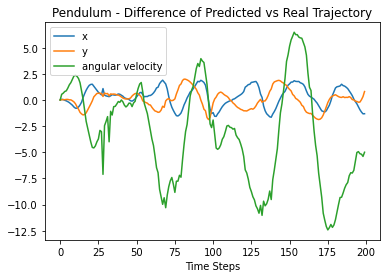

In [15]:
diff = states_i - states.to('cpu')
diff = diff.detach().numpy()
plt.plot(diff[0,:,0], label = "x")
plt.plot(diff[0,:,1], label = "y")
plt.plot(diff[0,:,2], label = "angular velocity")
plt.legend()
plt.xlabel("Time Steps")
#plt.ylim([-6,6])
#plt.ylabel("Loss")
plt.title("Pendulum - Difference of Predicted vs Real Trajectory")
plt.savefig("figures/pendulum_test_diff_mse_2.pdf")

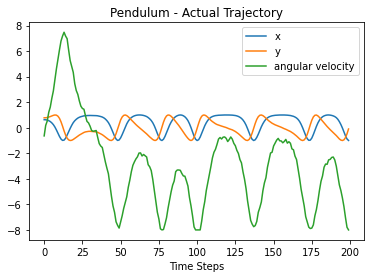

In [16]:
plt.plot(states_i[0,:,0], label = "x")
plt.plot(states_i[0,:,1], label = "y")
plt.plot(states_i[0,:,2], label = "angular velocity")
plt.legend()
plt.xlabel("Time Steps")
#plt.ylabel("Loss")
#plt.ylim([-6,6])
plt.title("Pendulum - Actual Trajectory")
plt.savefig("figures/pendulum_test_real_mse_2.pdf")

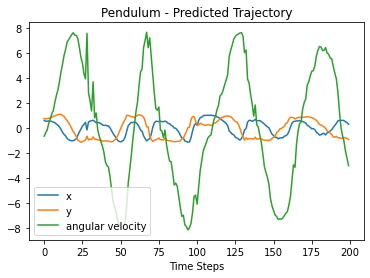

In [17]:
states = states.detach().cpu()
plt.plot(states[:,0], label = "x")
plt.plot(states[:,1], label = "y")
plt.plot(states[:,2], label = "angular velocity")
plt.legend()
plt.xlabel("Time Steps")
#plt.ylabel("Loss")
#plt.ylim([-6,6])
plt.title("Pendulum - Predicted Trajectory")
plt.savefig("figures/pendulum_pred_real_mse_2.pdf")
